In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from statistics import mode
from sklearn.cluster import KMeans

In [2]:
df = pd.read_csv('../data/train.csv')

In [3]:
df = df.sort_values(['locdt', 'loctm'])

In [4]:
df

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,iterm,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey
498036,6716,12765,101514,966.58,4,62,N,2,N,N,...,2,1,29.0,247,34949,N,5817,102,0,1119159
900910,5575,34837,60869,1071.10,5,62,Y,8,N,N,...,0,1,40.0,203,33794,N,2138,44,0,641444
1429123,6769,22630,110573,438.21,5,62,N,5,N,N,...,0,1,45.0,251,79257,N,3588,102,0,188670
739925,6767,91588,208961,1174.17,5,62,N,5,N,N,...,0,1,48.0,293,14765,N,5817,102,0,1475737
434529,3198,84148,180103,367.29,5,60,N,5,N,N,...,0,1,51.0,251,68966,N,3982,38,0,641443
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,6032,6602,192261,626.93,5,62,Y,2,N,N,...,0,90,235916.0,248,84802,N,5817,102,0,325840
1502777,5720,152795,151050,287.02,5,62,Y,8,N,N,...,0,90,235922.0,295,67613,N,5758,92,0,784237
577420,6777,3324,171229,625.35,5,62,Y,8,N,N,...,0,90,235953.0,257,2572,Y,5817,102,0,1459862
1034666,3348,150457,143382,277.55,5,62,Y,8,N,N,...,0,90,235957.0,289,54828,N,3460,46,0,784238


In [16]:
# filter > 19 筆交易紀錄 for 卡號
fraud = df[df["fraud_ind"] == 1]
non_fraud = df[df["fraud_ind"] == 0]
card_tx_hist = {}

for idx, row in tqdm(non_fraud.iterrows()):
    cano = row["cano"]
    if cano in card_tx_hist:
        card_tx_hist[cano].append(idx)
    else:
        card_tx_hist[cano] = [idx]

0it [00:00, ?it/s]

In [17]:
tx_sample = []

for k, v in tqdm(card_tx_hist.items()):
    if len(v) > 17:
        card_tx_hist[k] = v[int(len(v) * 0.3) : ]
    tx_sample += card_tx_hist[k]

  0%|          | 0/128439 [00:00<?, ?it/s]

In [18]:
sample_df = df.loc[tx_sample]

In [19]:
conam_pct = df.loc[:,['cano','conam']].groupby('cano').mean()

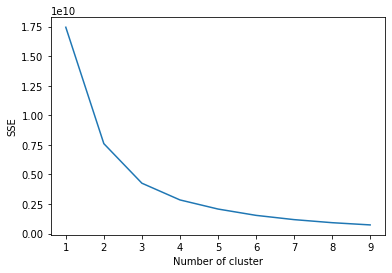

In [9]:
sse = {}

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(conam_pct)
#   oversea_pct["clusters"] = kmeans.labels_
#   print(oversea_pct["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center

plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

In [20]:
kmeans = KMeans(n_clusters=5, max_iter=1000).fit(conam_pct)

In [21]:
conam_pct["cluster"] = kmeans.labels_

In [22]:
sampling_cards = pd.Series(conam_pct[conam_pct["cluster"] == 0].index)
sampling_df_c1 = sample_df[sample_df["cano"].isin(sampling_cards)].sample(frac=0.8)

In [23]:
sampling_cards = pd.Series(conam_pct[conam_pct["cluster"] == 1].index)
sampling_df_c2 = sample_df[sample_df["cano"].isin(sampling_cards)].sample(frac=0.8)

In [24]:
sampling_df_c = [sampling_df_c1, sampling_df_c2]
for i in range(2, 5):
    sampling_df_c.append(sample_df[sample_df["cano"].isin(pd.Series(conam_pct[conam_pct["cluster"] == i].index))])

In [26]:
final_df = pd.concat((*sampling_df_c, fraud), 0)

In [60]:
df = final_df
df

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,locdt,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,oversea_flag
895531,6716,114640,98294,513.80,5,62,N,2,N,N,...,20,143817.0,432,38552,N,5817,102,0,1630782,0
920201,6032,14362,100170,743.75,5,62,Y,2,N,N,...,61,111526.0,247,82174,N,5817,102,0,289441,0
259637,6032,156491,80716,865.04,5,62,N,5,N,N,...,52,114341.0,251,84421,N,5858,102,0,460899,0
804203,6648,37251,98148,652.03,5,62,N,2,N,N,...,61,121918.0,411,100015,N,5817,102,0,1584397,0
1167528,6678,125594,105140,602.19,5,62,N,5,N,N,...,86,215219.0,250,22783,N,5817,102,0,1671819,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1252173,3207,46557,184894,360.30,5,61,Y,8,N,N,...,90,234859.0,257,10518,N,1457,104,2,784265,1
972513,6540,139705,133946,953.67,5,61,Y,2,N,N,...,90,235007.0,288,55807,N,6580,104,0,1927692,1
1282846,6540,139705,133946,954.10,5,61,Y,2,N,N,...,90,235032.0,288,55807,N,6580,104,0,1927689,1
356436,6467,86824,106395,101.61,4,61,Y,2,N,N,...,90,235140.0,320,65334,N,1495,104,0,1927696,1


In [61]:
# extract 海外消費，考量目前時間回填訓練資料
df["oversea_flag"] = df.stocn != 102
df["oversea_flag"] = df["oversea_flag"].astype(int)

In [ ]:
# extract 網購消費，考量目前時間回填訓練資料

In [62]:
# MCC消費種類分群, 各卡MCC消費占比, 各卡MCC消費類型分群
df = df.sort_values(['locdt', 'loctm'])

In [39]:
mcc_most_freq = []
hist = {}

for idx, (txid, row) in tqdm(enumerate(df.iterrows())):
    cano = row["cano"]
    
    if cano in hist:
        hist[cano].append(row["mcc"])
    else:
        hist[cano] = [row["mcc"]]
    mcc_most_freq.append(mode(hist[cano]))

0it [00:00, ?it/s]

In [63]:
df["most_freq"] = mcc_most_freq

In [64]:
df

,acqic,bacno,cano,conam,contp,csmcu,ecfg,etymd,flbmk,flg_3dsmk,...,loctm,mcc,mchno,ovrlt,scity,stocn,stscd,txkey,oversea_flag,most_freq
498036,6716,12765,101514,966.58,4,62,N,2,N,N,...,29.0,247,34949,N,5817,102,0,1119159,0,247
900910,5575,34837,60869,1071.10,5,62,Y,8,N,N,...,40.0,203,33794,N,2138,44,0,641444,1,203
402754,3348,84117,186292,453.88,5,62,Y,8,N,N,...,126.0,380,54238,N,6580,38,0,641445,1,380
500318,6351,33965,158580,2352.63,5,61,N,2,N,N,...,214.0,201,56486,N,3940,32,2,1832978,1,201
228566,5975,120861,82876,247.76,2,62,N,2,N,N,...,222.0,264,96344,N,5817,102,0,1333371,0,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,6032,6602,192261,626.93,5,62,Y,2,N,N,...,235916.0,248,84802,N,5817,102,0,325840,0,306
1502777,5720,152795,151050,287.02,5,62,Y,8,N,N,...,235922.0,295,67613,N,5758,92,0,784237,1,457
577420,6777,3324,171229,625.35,5,62,Y,8,N,N,...,235953.0,257,2572,Y,5817,102,0,1459862,0,251
1034666,3348,150457,143382,277.55,5,62,Y,8,N,N,...,235957.0,289,54828,N,3460,46,0,784238,1,247


In [65]:
# data cleaning

# 分佈相似：contp、csmcu
# 丟：etymd、flbmk、iterm、locdt、loctm、ovrlt、stscd、tckey
important_cols = ["acqic", "bacno", "cano", "conam", "contp", "ecfg", "flg_3dsmk", "hcefg", "insfg", "mcc", "mchno", "scity", "stocn", "oversea_flag", "most_freq"]
label = df["fraud_ind"]
df = df[important_cols]

In [66]:
df

,acqic,bacno,cano,conam,contp,ecfg,flg_3dsmk,hcefg,insfg,mcc,mchno,scity,stocn,oversea_flag,most_freq
498036,6716,12765,101514,966.58,4,N,N,5,Y,247,34949,5817,102,0,247
900910,5575,34837,60869,1071.10,5,Y,N,5,N,203,33794,2138,44,1,203
402754,3348,84117,186292,453.88,5,Y,N,5,N,380,54238,6580,38,1,380
500318,6351,33965,158580,2352.63,5,N,N,5,N,201,56486,3940,32,1,201
228566,5975,120861,82876,247.76,2,N,N,5,N,264,96344,5817,102,0,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,6032,6602,192261,626.93,5,Y,N,5,N,248,84802,5817,102,0,306
1502777,5720,152795,151050,287.02,5,Y,N,5,N,295,67613,5758,92,1,457
577420,6777,3324,171229,625.35,5,Y,N,5,N,257,2572,5817,102,0,251
1034666,3348,150457,143382,277.55,5,Y,N,5,N,289,54828,3460,46,1,247


In [67]:
# normalization (數值、類別)、one-hot encoding
# 欄位類別判定
col_names_cont = [] # 數值型資料
col_names_disc = [] # 類別型資料
col_has_na = [] # 待補NA資料
for c in df.keys():
    uni = df[c].unique()
    n_na = pd.isna(df[c]).sum() # NA 數量
    if n_na > 0:
        col_has_na.append(c)       
    if len(uni) < 200 :
        print(f"{c}: uni={uni}")
        col_names_disc.append(c)
    else:
        info = [ df[c].max(), df[c].min(), df[c].mean(), df[c].std()]
        info = [ round(x,2) for x in info ]
        offset = 1 if n_na else 0
        diversity = (len(uni)-offset)/(len(df)-n_na)
        print(f"{c}: dtype={df[c].dtype}, n_na={n_na}")
        print("       max={}, min={}, mean={}, std={}, diversity={:.2f}%".format(*info, diversity*100 ) )
        if diversity == 1.0:
            print(f"       Delete col [{c}] due to diversity is 100% ")
        else:
            col_names_cont.append(c)

acqic: dtype=int64, n_na=0
       max=6884, min=0, mean=5995.66, std=1529.67, diversity=0.49%
bacno: dtype=int64, n_na=0
       max=163884, min=1, mean=82096.91, std=47331.66, diversity=8.29%
cano: dtype=int64, n_na=0
       max=213334, min=0, mean=108820.9, std=61026.82, diversity=11.24%
conam: dtype=float64, n_na=0
       max=7208.77, min=0.0, mean=660.92, std=414.54, diversity=5.48%
contp: uni=[4 5 2 3 6 0 1]
ecfg: uni=['N' 'Y']
flg_3dsmk: uni=['N' 'Y' nan]
hcefg: uni=[5 1 6 8 2 0 7 9 3]
insfg: uni=['Y' 'N']
mcc: dtype=int64, n_na=0
       max=459, min=0, mean=298.5, std=78.04, diversity=0.04%
mchno: dtype=int64, n_na=0
       max=103307, min=0, mean=55982.75, std=30788.69, diversity=6.88%
scity: dtype=int64, n_na=0
       max=6671, min=0, mean=4753.79, std=1978.08, diversity=0.44%
stocn: uni=[102  44  38  32  46 104  75  36  52  93  42  20  27  26  25  92   6  48
  61  68  62  16   2  73  78  55  95  98  41 106  18  17  50   1  80  45
  49  94  90   0   9   5 101  84  40 107  10  8

In [68]:
df = df.fillna("NA")

In [69]:
df

,acqic,bacno,cano,conam,contp,ecfg,flg_3dsmk,hcefg,insfg,mcc,mchno,scity,stocn,oversea_flag,most_freq
498036,6716,12765,101514,966.58,4,N,N,5,Y,247,34949,5817,102,0,247
900910,5575,34837,60869,1071.10,5,Y,N,5,N,203,33794,2138,44,1,203
402754,3348,84117,186292,453.88,5,Y,N,5,N,380,54238,6580,38,1,380
500318,6351,33965,158580,2352.63,5,N,N,5,N,201,56486,3940,32,1,201
228566,5975,120861,82876,247.76,2,N,N,5,N,264,96344,5817,102,0,264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,6032,6602,192261,626.93,5,Y,N,5,N,248,84802,5817,102,0,306
1502777,5720,152795,151050,287.02,5,Y,N,5,N,295,67613,5758,92,1,457
577420,6777,3324,171229,625.35,5,Y,N,5,N,257,2572,5817,102,0,251
1034666,3348,150457,143382,277.55,5,Y,N,5,N,289,54828,3460,46,1,247


In [70]:
from sklearn.preprocessing import StandardScaler

df_cont = df[col_names_cont].copy()
scaler = StandardScaler()
X_cont = scaler.fit_transform(df_cont)
df_cont = pd.DataFrame(data=X_cont, index=df.index, columns=col_names_cont)
df_cont.head()

,acqic,bacno,cano,conam,mcc,mchno,scity,most_freq
498036,0.470913,-1.464811,-0.119733,0.737339,-0.659896,-0.683165,0.537493,-0.634581
900910,-0.275001,-0.998485,-0.785752,0.989474,-1.223733,-0.720679,-1.322389,-1.186135
402754,-1.730873,0.042679,1.269461,-0.499452,1.044431,-0.056668,0.923220,1.032615
500318,0.232299,-1.016908,0.815365,4.080920,-1.249362,0.016345,-0.411406,-1.211206
228566,-0.013506,0.818989,-0.425139,-0.996677,-0.442050,1.310912,0.537493,-0.421481


In [71]:
df_cont.describe()

,acqic,bacno,cano,conam,mcc,mchno,scity,most_freq
count,1.140769e+06,1.140769e+06,1.140769e+06,1.140769e+06,1.140769e+06,1.140769e+06,1.140769e+06,1.140769e+06
mean,-2.095311e-16,-2.112751e-17,7.212753e-17,1.437144e-15,-1.814898e-16,2.942405e-17,1.366561e-16,-8.696101e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.919584e+00,-1.734483e+00,-1.783166e+00,-1.594351e+00,-3.825075e+00,-1.818290e+00,-2.403234e+00,-3.705732e+00
25%,-8.929655e-03,-8.591908e-01,-8.468067e-01,-5.512684e-01,-6.086380e-01,-7.206788e-01,-5.094807e-01,-5.969755e-01
50%,4.709133e-01,-3.019353e-03,1.589636e-02,-1.665050e-01,-4.420496e-01,1.099837e-01,5.374930e-01,-4.340165e-01
75%,5.055613e-01,8.646032e-01,8.703735e-01,3.781703e-01,5.702950e-01,7.540841e-01,5.374930e-01,5.688083e-01
max,5.807411e-01,1.727958e+00,1.712577e+00,1.579543e+01,2.056776e+00,1.537067e+00,9.692243e-01,2.022904e+00


In [72]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

df_disc = df[col_names_disc].copy()
les = {}
for c in col_names_disc:
    le = LabelEncoder()
    df_disc.loc[:,c] = le.fit_transform(df_disc.loc[:,c])
    les.update({c:le})
df_disc.head()

ohe = OneHotEncoder(sparse=False)
X_disc = ohe.fit_transform(df_disc)
# cut_point = ohe.feature_indices_
# print("feature cut point: ", cut_point)

new_col_names_disc = []
for c in col_names_disc: 
    le = les[c]
    new_col_names_disc += [ c+'_'+str(cl) for cl in le.classes_ ]
assert len(new_col_names_disc) == X_disc.shape[1]

df_disc = pd.DataFrame(data=X_disc, index=df.index, columns=new_col_names_disc)

In [81]:
import pickle

with open("../label_encoders.pkt", "wb") as f:
    pickle.dump(les, f)

In [83]:
df = pd.concat((df_cont, df_disc), 1)
df["fraud_ind"] = label

In [84]:
df

,acqic,bacno,cano,conam,mcc,mchno,scity,most_freq,contp_0,contp_1,...,stocn_100,stocn_101,stocn_102,stocn_104,stocn_105,stocn_106,stocn_107,oversea_flag_0,oversea_flag_1,fraud_ind
498036,0.470913,-1.464811,-0.119733,0.737339,-0.659896,-0.683165,0.537493,-0.634581,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
900910,-0.275001,-0.998485,-0.785752,0.989474,-1.223733,-0.720679,-1.322389,-1.186135,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
402754,-1.730873,0.042679,1.269461,-0.499452,1.044431,-0.056668,0.923220,1.032615,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
500318,0.232299,-1.016908,0.815365,4.080920,-1.249362,0.016345,-0.411406,-1.211206,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
228566,-0.013506,0.818989,-0.425139,-0.996677,-0.442050,1.310912,0.537493,-0.421481,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389804,0.023757,-1.595020,1.367270,-0.082002,-0.647081,0.936034,0.537493,0.105002,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1502777,-0.180209,1.493675,0.691976,-0.901970,-0.044800,0.377744,0.507666,1.997834,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
577420,0.510791,-1.664276,1.022635,-0.085813,-0.531751,-1.734753,0.537493,-0.584440,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0
1034666,-1.730873,1.444279,0.566327,-0.924814,-0.121687,-0.037506,-0.654065,-0.634581,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [86]:
df.to_csv("../data/preprocess_train.csv", index_label="txkey")